In [1]:
import sys
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
import pytesseract
from IPython.core.display import HTML

%matplotlib inline

def imshow(tit, image):
    plt.figure(figsize=(12, 8))
    if len(image.shape) == 3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image, cmap='gray')
    plt.title(tit)
    plt.axis('off')    
    plt.show()
    
    
DIR = './vision/'

# 객체 검출

## 보행자 검출

In [4]:
cap = cv2.VideoCapture(DIR + 'vtest.avi')

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

while True:
    ret, frame = cap.read()
    
    if not ret:
        break
    detected, _ = hog.detectMultiScale(frame)
    
    for (x,y,w,h) in detected:
        c = (random.randint(0,255),
            random.randint(0,255),
            random.randint(0,255))
        cv2.rectangle(frame, (x,y), (x+w, y+h),c,3)
        
    cv2.imshow("frame", frame)
    if cv2.waitKey(10) == 27:
        break

cap.release()
cv2.destroyAllWindows()

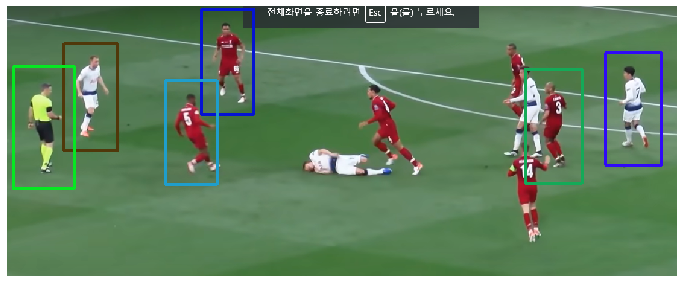

In [7]:
frame = cv2.imread(DIR + 'hogtest.png')

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

fgbg = cv2.createBackgroundSubtractorMOG2(varThreshold=100)


fgmask = fgbg.apply(frame)
detected, _ = hog.detectMultiScale(frame)
    
for (x,y,w,h) in detected:
    c = (random.randint(0,255),
        random.randint(0,255),
        random.randint(0,255))
    cv2.rectangle(frame, (x,y), (x+w, y+h),c,3)
        
imshow("", frame)

In [24]:
def detectHuman(frame):
    
    frame = cv2.imread(frame)

    detected, _ = hog.detectMultiScale(frame)

    for (x,y,w,h) in detected:
        c = (random.randint(0,255),
             random.randint(0,255),
             random.randint(0,255))
        cv2.rectangle(frame, (x,y), (x+w, y+h),c,3)
    return detected


In [25]:
detectHuman(DIR + 'hogtest.png')

array([[ 94,  62,  89, 177],
       [992,  77,  93, 186],
       [859, 104,  94, 189],
       [ 10, 100, 101, 202],
       [322,   5,  87, 174],
       [262, 123,  86, 172]], dtype=int32)

### 웹으로 동영상 연동

In [34]:
%%writefile server.py

import cv2
import numpy as np
import random
import io

from flask import Flask, request, render_template, redirect, make_response, Response
import requests


app = Flask(__name__)

vc = cv2.VideoCapture('./vision/vtest.avi')

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

datas = []

def detectHuman(frame):

    detected, _ = hog.detectMultiScale(frame)

    for (x,y,w,h) in detected:
        c = (random.randint(0,255),
             random.randint(0,255),
             random.randint(0,255))
        cv2.rectangle(frame, (x,y), (x+w, y+h),c,3)
        
    return detected

@app.route('/')
def index():
    
    html = """
        보행자 검출 Test
        <img src=/video_feed width=320 height=240>
    """
    return html
    

def gen():
    global vc
    global datas
    while True:
        read_return_code, frame = vc.read()
        
        if not read_return_code :
            vc = cv2.VideoCapture('./vision/vtest.avi')
            break
        
        detectHuman(frame)
        
        encode_return_code, image_buffer = cv2.imencode('.jpg', frame)
        io_buf = io.BytesIO(image_buffer)
        yield (b'--frame\r\n'
               b'Content-Type: image/jpeg\r\n\r\n' + io_buf.read() + b'\r\n')


@app.route('/video_feed')
def video_feed():
    """Video streaming route. Put this in the src attribute of an img tag."""
    return Response(
        gen(),
        mimetype='multipart/x-mixed-replace; boundary=frame'
    )

@app.route('/view')
def view():
    global datas
    return str(datas)
    
if __name__ == '__main__':
    app.run(host='0.0.0.0', debug=True, port=8000)

Overwriting server.py
